In [15]:
import mlrun

In [16]:
project = mlrun.get_or_create_project(name="schedule-workflow", context="./")

> 2024-10-08 16:26:02,711 [info] Project loaded successfully: {'project_name': 'schedule-workflow'}


In [17]:
project.set_source(source="git://github.com/xsqian/mlrun-github-example.git#main", pull_at_runtime=True)

In [18]:
%%writefile src/func1.py
def handler():
    print("inside func1")
    return "return from func1"

Overwriting src/func1.py


In [19]:
fn = project.set_function(
    name="function1",
    func="src/func1.py",
    kind="job",
    image="mlrun/mlrun:1.4.1",
    handler="handler",
    with_repo=True,
)

In [20]:
fn=project.get_function("function1")

In [ ]:
fn.run()

> 2024-10-08 16:26:06,379 [info] Storing function: {'name': 'function1-handler', 'uid': 'daebb8c187fd4b6f92eb6a647fa24da7', 'db': 'http://mlrun-api:8080'}
> 2024-10-08 16:26:07,006 [info] Job is running in the background, pod: function1-handler-wcvjs
> 2024-10-08 16:26:10,346 [info] Server and client versions are not the same but compatible: {'parsed_server_version': VersionInfo(major=1, minor=6, patch=2, prerelease=None, build=None), 'parsed_client_version': VersionInfo(major=1, minor=4, patch=1, prerelease=None, build=None)}
Traceback (most recent call last):
  File "/usr/local/bin/mlrun", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.9/site-packages/click/core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/click/core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.9/site-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.i

In [83]:
%%writefile src/schedule-workflow.py

from kfp import dsl
import mlrun


# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="scheduled-pipeline",
    description="Example of scheduled pipeline"
)
def pipeline():
    
    # Get current project
    project = mlrun.get_current_project()

    f1 = project.get_function("function1")

    # Ingest the data set
    f1_rs = project.run_function(
        function=f1
    )

    project.run_function(
        function=f1
    ).after(f1_rs)

Writing src/schedule-workflow.py


In [84]:
project.set_workflow(workflow_path='src/schedule-workflow.py',name='testing-schedule',schedule='*/10 * * * *')

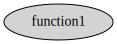

In [ ]:
project.save()
project.run('testing-schedule', watch=True, dirty=True)

In [74]:
project.run('testing-schedule', watch=True, schedule=True)

> 2023-09-15 18:55:29,282 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-09-15 18:55:29,287 [info] executing workflow scheduling 'workflow-runner-schedule' remotely with kfp engine
> 2023-09-15 18:55:29,290 [info] Storing function: {'name': 'schedule', 'uid': '2fac3efcf67b4a68a9643c72bae6bf7f', 'db': None}
> 2023-09-15 18:55:29,723 [info] task schedule created: {'schedule': '*/10 * * * *', 'project': 'schedule-workflow', 'name': 'schedule'}


In [75]:
# mlrun.get_run_db().delete_schedule(project=project.name,name='testing-schedule')